# Parallelize Python code with Dask Delayed

## General Python code

In [1]:
from time import sleep

In [2]:
def inc(x):
    sleep(1)
    return x + 1

def dec(x):
    sleep(1)
    return x - 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time

a = inc(1)
b = dec(1)
c = add(a, b)

CPU times: user 1.29 ms, sys: 2.21 ms, total: 3.5 ms
Wall time: 3.01 s


In [4]:
%%time

l = []

for i in range(10):
    a = inc(i)
    b = dec(i)
    c = add(a, b)
    l.append(c)

CPU times: user 2.87 ms, sys: 2.11 ms, total: 4.98 ms
Wall time: 30.1 s


## Dask Delayed

In [5]:
from dask.distributed import Client, progress
client = Client(n_workers=1)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58266,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58270,Total threads: 8
Dashboard: http://127.0.0.1:58271/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:58268,


Open the dashboards!

In [6]:
from dask import delayed, compute, visualize

In [7]:
%%time

l = []

for i in range(10):
    a = delayed(inc)(i)
    b = delayed(dec)(i)
    c = delayed(add)(a, b)
    l.append(c)

CPU times: user 2.42 ms, sys: 699 µs, total: 3.12 ms
Wall time: 2.82 ms


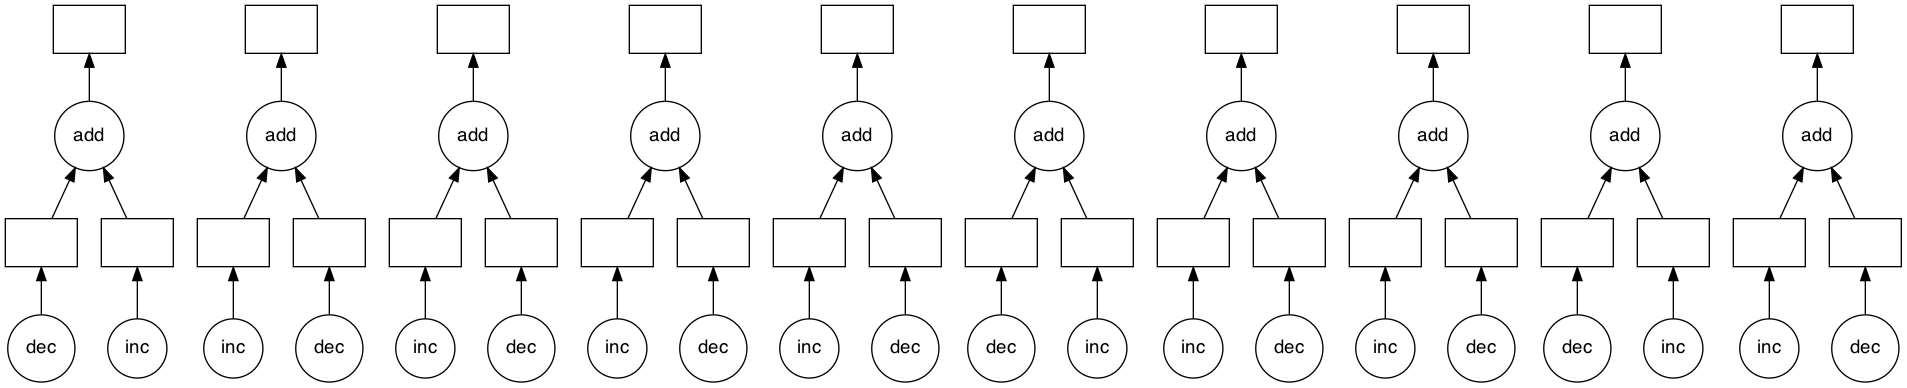

In [8]:
visualize(*l)

In [9]:
%%time

l = compute(*l)
l

CPU times: user 192 ms, sys: 84.8 ms, total: 277 ms
Wall time: 4.17 s


(0, 2, 4, 6, 8, 10, 12, 14, 16, 18)

### Alternatively...

In [10]:
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def dec(x):
    sleep(1)
    return x - 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

Or:

In [ ]:
# inc = delayed(inc)
# dec = delayed(dec)
# add = delayed(add)

In [11]:
%%time

l = []

for i in range(10):
    a = inc(i)
    b = dec(i)
    c = add(a, b)
    l.append(c)
    
l = compute(*l)

CPU times: user 137 ms, sys: 21 ms, total: 158 ms
Wall time: 4.05 s


## Another example: pandas

In [15]:
!wget https://coiled-datasets.s3.us-east-2.amazonaws.com/seattle-library-checkouts/checkouts-subset.csv 

--2021-08-10 13:49:25--  https://coiled-datasets.s3.us-east-2.amazonaws.com/seattle-library-checkouts/checkouts-subset.csv
Resolving coiled-datasets.s3.us-east-2.amazonaws.com (coiled-datasets.s3.us-east-2.amazonaws.com)... 52.219.101.34
Connecting to coiled-datasets.s3.us-east-2.amazonaws.com (coiled-datasets.s3.us-east-2.amazonaws.com)|52.219.101.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3945918574 (3,7G) [text/csv]
Saving to: ‘checkouts-subset.csv.1’

checkouts-subset.cs 100%[===================>]   3,67G  2,20MB/s    in 16m 50s 

2021-08-10 14:06:16 (3,73 MB/s) - ‘checkouts-subset.csv.1’ saved [3945918574/3945918574]



In [16]:
import pandas as pd

In [37]:
%%time

ddf = delayed(pd.read_csv)("checkouts-subset.csv", 
                           engine='python', 
                           error_bad_lines=False) # with delayed

CPU times: user 356 µs, sys: 37 µs, total: 393 µs
Wall time: 378 µs


In [38]:
%%time

result = ddf.groupby("UsageClass").Checkouts.sum()

CPU times: user 371 µs, sys: 18 µs, total: 389 µs
Wall time: 385 µs


In [39]:
result

Delayed('sum-9d60313e-d230-4ccd-98c1-0ff95cc2edb0')

In [40]:
result.compute()

/Users/rpelgrim/mambaforge/envs/dask-delayed/lib/python3.8/site-packages/distributed/worker.py:3723: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  return func(*map(execute_task, args))
Skipping line 573200: unexpected end of data
distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function apply at 0x10331fd30>, <function read_csv at 0x126d798b0>, ['checkouts-subset.csv'], (<class 'dict'>, [['error_bad_lines', False]])))
kwargs:    {}
Exception: ParserError('Error tokenizing data. C error: EOF inside string starting at row 573199')



ParserError: Error tokenizing data. C error: EOF inside string starting at row 573199

In [17]:
client.close()